# Ride Share Analysis and Web Application

## Import dependencies and project configurations

In [126]:
import calendar
import datetime
import logging
import matplotlib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from typing import Any, Callable, Dict, List, Optional, Union

from utils.configs import CHART_ANVIL_API, STATS_ANVIL_API
from utils.constants import KM_TO_MI, STANDARD_RIDE_TYPES

# configure pandas to show more rows and columns
pd.get_option("max_columns", None)
pd.set_option('max_rows', 200)

# configure matplotlib to show more datapoints
matplotlib.rcParams['agg.path.chunksize'] = 100000

# configure logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
handler = logging.FileHandler('logs.log')
logger.addHandler(handler)

# Utility Functions

### Cleaning and Parsing Utils

In [119]:
def counter(f: Callable):
    """
    Increment a counter on a function everytime it is called. 
    Used to determine the number of ignored records in a latter function.
    
    :params f: function input
    :type f: Callable
    :return
    """
    def wrapped(*args, **kwargs):
        wrapped.count+=1
        result = f(*args, **kwargs)
        return result
    wrapped.count = 0
    return wrapped

In [120]:
@counter
def ignored_counter():
    """This function is called when an abnormalis product_desciption record is found."""
    pass

In [121]:
def fill_na(column: pd.Series) -> pd.Series:
    """
    if type float or object,
    fill null values by column type
    
    :param merchant: DataFrame column
    :type merchant: pd.Series
    :rtype: pd.Series
    :return column with filled null values
    
    """
    if column.dtypes == np.float64:
        column = column.fillna(0.0)
    if column.dtypes == "O":
        column = column.fillna("N/A")
    else:
        column = column
    return column

In [122]:
def parse_ride_data(data: pd.Series) -> pd.Series:
    """
    Split and clean traditional ride data into the type of ride, distance travel, and duration of the ride.
    
    if non traditional ride data record detected,
    add columns and values to dataframe
    
    :param data: Rows from Dataframe
    :type data: pd.Series
    :rtype: pd.Series
    :return: dataframe with newly added columns and values
    
    """
    merchant, ride_data = data['merchant_name'], data['product_description']
    try:
        if merchant == "Uber":
            if "|" in ride_data:
                ride_info, duration_data = ride_data.split("|")
                ride_type, distance_data = ride_info.split(" ", 1)
            else:
                ride_type, distance_data, duration_data = ride_data, "N/A", "N/A"
        elif merchant == "Lyft":
            if "(" in ride_data:
                ride_type, travel_data = ride_data.split("(")
                travel_data = travel_data[:-1]
                distance_data, duration_data = travel_data.split(",")
            else:
                ride_type, distance_data, duration_data = ride_data, "N/A", "N/A"
        else:
            ride_type, distance_data, duration_data = ride_data, "N/A", "N/A"
    except: 
        # this should trigger in the case where data meets the intiatal condition of either containing "|" 
        # or "(" but does not follow the remaining tradition conventions ie. abonormal record (examples: additional delimiters,
        # spacing issues, too many to unpack, etc)
        
        ignored_counter()
        logger.info(f"{ride_data} was ignored")
        ride_type, distance_data, duration_data = ride_data, "N/A", "N/A"
    data['ride_type'] = ride_type.strip(),
    data['distance_data'] =  distance_data.strip()
    data['duration_data'] =  duration_data.strip()
    return data

### API utils

In [125]:
def remap_dict(dictionary: Dict[str,str]) -> List[str]:
    """
    flatten pandas statistics to be read by API.
    
    :params dictionary: pandas statistics in dictionary format
    :type dictionary: dict
    :rtype list
    :return list of dictionaries of stats data
    """
    res = []
    for key, value in dictionary.items():
        if isinstance(value, dict):
            new_dictionary = {'name': key, **value}
            res.append(new_dictionary)
        else:
            res.append({key: value})
    return res

## Import and clean data

In [7]:
data = pd.read_csv("RideShareDataNew.csv") # read data DO NOT RUN data is stored below

## Cleaning Strategy

### Filling null values based on data type - fill_Na

#### Function Description

First I am replacing null values based on the column data type. The default NaN made it difficult to filter, identify, and parse the information. I opted to replace float columns with 0.0 and object/string columns in "N/A" for easy of future transfermation and personal comfortability. This is not completely necessary, but given the time constraint of the assignment I opted to make the data as easy to work with as possible to spend more time on additional features

### Splitting product descriptions - parse_ride_data

#### Function Description

The product description contains many different types of products each in a unique and somewhat inconsistent format. Given the large amount of data I did not find it time efficient to identify each product type and its format/excpetions. From my brief scan of the column it looks like it include traditional ride shares for Uber and Lyft, meal deliveries, and what I assume to be giftcard purchases via a reseller. I decided to focus my attention on cleaning, parsing and splitting traditional ride share data into its own column in the dataframe. in the parse_ride_data function I do just that and return "N/A" for cases that are not traditional ride shares. Data life-cycle: product_description -> ride_type, ride_distance, ride_duration. Moreover I found many variations to the traditional format, given the time constraints I did not believe would to. (Example of an abnormal product_description = "UberX UberX 2.36 miles | 5 min 2.36 miles | 5 min")

#### Function Bugs

When parsing data this function takes the ride_type value which is a string during processing and returns it as a tuple to the dataframe column. This is corrected during additional cleaning later. (Attempted to correct within the function with no success). 

In [ ]:
# replace null values
filtered_data = data.copy()
filtered_data = filtered_data.apply(fill_na, axis=0)

# add columns for ride information in product description colum
filtered_data = filtered_data.apply(parse_ride_data, axis=1)

In [169]:
%store filtered_data # store filtered data DO NOT RUN AGAIN (10 hour long process)

Stored 'filtered_data' (DataFrame)


In [38]:
%store -r filtered_data  # retrieve stored data

no stored variable or alias #
no stored variable or alias retrieve
no stored variable or alias stored
no stored variable or alias data


### Additional Cleaning and Filtering

- Converted ride_type from tuple to string. 
- Convert order_time to datetime object. 
- Filter order from 2020 onward. 
- Parse and add distance and distance_metric columns on distance_data using regex example: "2.21 miles" &rarr; 2.21 | "miles". Convert distance to int. Standardize distance metric to abbreviations (example: "miles" &rarr; "mi"). Lastly convert kilometer distances to miles. 

In [39]:
# additional cleaning from parse_ride_data function
filtered_data['ride_type'] = filtered_data['ride_type'].apply(lambda x: x[0] if type(x) == tuple else x)
filtered_data['order_time'] = pd.to_datetime(filtered_data['order_time'], infer_datetime_format=True, errors='coerce')

# convert to datetime obj
df_2020 = filtered_data[filtered_data['order_time'] > datetime.datetime(2020,1,1)]

# exact number and metric using regex
df_distance_2020 = df_2020.copy()
df_distance_2020['distance'] = df_distance_2020['distance_data'].str.extract('(^\d*[.]?\d*)')
df_distance_2020['distance_metric'] = df_distance_2020['distance_data'].str.extract('([a-zA-Z]+)')

# convert to distance to float
df_distance_filtered_2020 = df_distance_2020.copy()
df_distance_filtered_2020 = df_distance_filtered_2020[df_distance_filtered_2020['distance_data'] != "N/A"]
df_distance_filtered_2020.loc['distance'] = df_distance_filtered_2020['distance'].astype(np.float64, errors='ignore')

# convert miltes to abbreviation
mi_mask = df_distance_filtered_2020['distance_metric'].isin(("mi", "miles"))
km_mask = df_distance_filtered_2020['distance_metric'].isin(("km", 'kilometers','kilometres'))
df_distance_filtered_2020.loc[mi_mask,'distance_in_miles'] = df_distance_filtered_2020[mi_mask]['distance']
df_distance_filtered_2020.loc[km_mask,'distance_in_miles'] = df_distance_filtered_2020[km_mask]['distance'].apply(lambda x: float(x)*KM_TO_MI)

# removing records without a distance and abnormal cases
df_distance_filtered_2020.dropna(subset=['distance_in_miles'], inplace=True)
df_distance_filtered_2020 = df_distance_filtered_2020.assign(value_per_mi = lambda x: pd.to_numeric(x['order_total_amount'])/pd.to_numeric(x['distance_in_miles']))
df_distance_filtered_2020['distance_in_miles'] = df_distance_filtered_2020['distance_in_miles'].astype(float)
df_distance_filtered_2020['value_per_mi'] = df_distance_filtered_2020['value_per_mi'].astype(float)

# drop uncessary columns
clean_truncated_2020_df = df_distance_filtered_2020.drop(columns=['order_number', 'email_time', 'update_time', 'insert_time', 'order_shipping', 'from_domain', 'email_subject', 'max_delivery_date', 'sku', 'item_id', 'distance','distance_metric', 'product_subtitle', 'product_category', 'max_update_time', 'delivery_date', 'distance_data', 'product_reseller','order_pickup','checksum', 'digital_transaction'])

### Set up Sample data

- Sample 10% of the data to reduce volume. 
- Add month column with calendar module

In [40]:
# since we are dealing with millions of datapoints even after only focusing on a subgroup, we want to take a random sample to readuce load on the program
sample_df = clean_truncated_2020_df.sample(frac=0.1)
sample_df['month_abbr'] = sample_df.order_time.apply(lambda x: calendar.month_abbr[x.month])
sample_df['distance_in_miles'] = sample_df['distance_in_miles'].astype(float)
sample_df['value_per_mi'] = sample_df['value_per_mi'].astype(float)

## Charts and Analysis

Simple Graph Analysis with plot/matplotlib

Plot parameters: Group data by month, filtered by order total, aggregated the data to save and plotted a simple bar char.
Result: I determined the most profitable month for all ride shares from 2020 onward was February and the least profitable was November

<AxesSubplot:title={'center':'Revenue per Month (2020-01 to 2021-11)'}, xlabel='Month (abbreviated)', ylabel='Revenue ($)'>

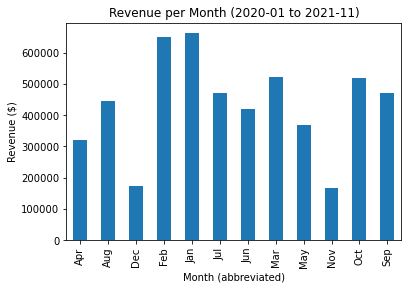

In [15]:
sample_df.groupby(by=['month_abbr'])['order_total_amount'].sum().plot(kind='bar', title='Revenue per Month (2020-01 to 2021-11)', xlabel = 'Month (abbreviated)', ylabel = 'Revenue ($)')

## API Utils

Establish connection between anvil API and notebook
The web app will give provide parameters and call the function, then display the result.

In [124]:
import anvil.server

anvil.server.connect(STATS_ANVIL_API)
logger.info("Connecting to anvil API...")

@anvil.server.callable()
def ride_type_desc_api(product: str) -> List[Dict[str,Any]]:
    """
    Fetch pandas describe results (general stats) on a ride type
    
    :params product: Ride type user wants to recieve stats on
    :type: product: str
    :rtype list
    :return stats list 
    """
    logger.info("Connection to anvil API established")
    
    if product in STANDARD_RIDE_TYPES:
        result = sample_df[sample_df['ride_type'] == str(product)].describe().round().to_dict()
    else:
        result = f"Error: ride type: {product} not currently available" # sending error message to API
    result_remap = remap_dict(result)
    return result_remap

Disconnecting from previous connection first...
Connecting to wss://anvil.works/uplink
Anvil websocket closed (code 1000, reason=b'')


INFO:__main__:Connecting to anvil API...


Anvil websocket open
Connected to "Default environment" as SERVER


In [108]:
import anvil.server
import anvil.media

logger.info("Connecting to anvil API...")

anvil.server.connect(CHART_ANVIL_API)


@anvil.server.callable()
def create_plot(grouby_name=None, filter_by=None, operation=None, kind=None, title=None, xlabel=None, ylabel=None, legend=False) -> Union[anvil.BlobMedia, str]:
    """
    Fetch chart
    
    params:
        grouby_name: Optional[str], filter_by: Optional[str], operation: Optional[str], kind: Optional[str],
        title: Optional[str], xlabel: Optional[str], ylabel: Optional[str], legend: Optional[bool] 
        
    :rtype anvill.BlombMedia
    :return chart image
    
    """
    logger.info("Connection to anvil API established")
    logger.info(f"creating new chart request for: {grouby_name=},{filter_by=},{kind=},{title=},{xlabel=},{ylabel=}")
    if not kind:
        kind = 'bar'
    df = sample_df
    try:
        if grouby_name:
            grouby_names =  grouby_name.split()
            df = df.groupby(by=grouby_names)
        if filter_by:
            filters = filter_by.split()
            df = df[filters]
        if operation:
            operations = operation.split()
            df = df.agg(operations)
        plot =  df.plot(kind=kind,title=title,xlabel=xlabel,ylabel=ylabel,legend=legend)
        
        if hasattr(plot, 'count'):
            return "Trying to return a multiplot, try making aggregate plot"
        fig = plot.get_figure()
        fig.savefig('fig.png')
        
        with open("fig.png", "rb") as image:
            image_file = image.read()
            image_file_bytes = bytes(image_file)
            
        return anvil.BlobMedia(content_type="image/png", content=image_file_bytes, name="fig_plot.png")
    except Exception as e:
        logger.error(f"Error: '{e}'' occured for request: {grouby_name=},{filter_by=},{kind=},{title=},{xlabel=},{ylabel=}")
        return f"Error: '{e}'' occured for request: {grouby_name=},{filter_by=},{kind=},{title=},{xlabel=},{ylabel=}" # sending error message to API

INFO:__main__:Connecting to anvil API...
